# **LAB: RIDGE REGRESSION AND THE LASSO**
Packages used:
 - `statsmodels` and `sklearn` for statistical tests and prediction;
 - and of course, `pandas` for data wrangling and organizing, as well as `matplotlib` and `seaborn` for pictures.

(see Readme for more information about the packages)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from itertools import combinations
import time


sns.set_theme(style="darkgrid")

We work with the `Hitters` data again, and will predict `Salary`. Remember to drop the missing values and get dummy variables for the categorical predictors.

In [6]:
hitters = pd.read_csv('data/Hitters.csv')
hitters.dropna(subset=['Salary'], inplace=True)
hitters = pd.get_dummies(hitters, drop_first=True)

We then scale our data and split it into predictors/targets; remember that `StandardScaler.fit()` returns an array; to keep our column names we make it into a dataframe.

In [247]:
X = hitters.drop(columns='Salary')
y = hitters['Salary']

## **1. Ridge regression**
The Ridge regression model is available as the class `Ridge` from `sklearn.linear_model`. We can pass a regularization parameter using the keyword argument `alpha` (the parameter that is denoted $\lambda$ in ISLR); set to $1$ by default. The `normalize` parameter tells the ridge regression to normalize each sample so it has unit length. The relative values of the predictors for each sample are kept, but the normalization process makes each sample weigh equally in the process. This is different from _standardization_, which normalizes each column and means every predictor should have roughly the same weight. 

We'll test a range of values for $\alpha$, from $10^{-2}$ to $10^{10}$, and store the results in a $19\times100$ numpy array; we're not storing the intercept in our array, since it is not subject to the regularization condition.

In [248]:
alphas = 10**np.linspace(10,-2,100)*0.5
coefs = np.array([])

from sklearn.linear_model import Ridge
ridgereg = Ridge(normalize=True)

for a in alphas:
    ridgereg.set_params(alpha=a)
    ridgereg.fit(X, y)
    coefs = np.concatenate((coefs, ridgereg.coef_))

coefs = coefs.reshape((100, 19))

Optionally, store the values in a dataframe for more legibility, and plot the $\ell_2$ norm of our coefficients:

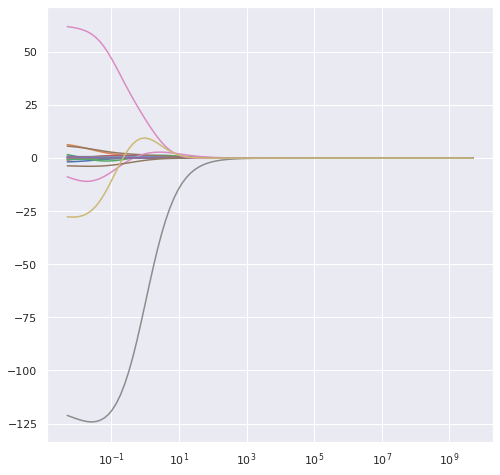

In [249]:
coef_df = pd.DataFrame(data=coefs, columns=list(X.columns), index=alphas)
l_2 =  np.fromiter((np.sqrt(sum(coef_df.iloc[i] ** 2)) for i in range(100)), dtype=float)

fig, ax = plt.subplots(figsize=(8,8))
plt.plot(alphas, coefs)
ax.set_xscale('log')

We can see the $\ell_2$ norm decreases as $\alpha$ increases.

Now let us try to evaluate our model. We'll do a 50/50 train/test split:

In [250]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.5, 
                                                    random_state=1)

We fit a model on the training set and compute its MSE on the test set:

In [251]:
from sklearn.metrics import mean_squared_error

def mse(alpha):
    ridgereg.set_params(alpha=alpha)
    ridgereg.fit(X_train, y_train)
    return mean_squared_error(ridgereg.predict(X_test), y_test)

A parameter $\alpha = 0$ corresponds to an ordinary least square linear regression. A very large $\alpha$ is similar to fitting a horizontal lign (with only an intercept) to the data. Here we compare these MSEs to the MSE for $\alpha = 4$, which seems to be an improvement on both extremes.

In [252]:
print(mse(0), mse(4), mse(10 ** 10))

116690.46856660162 106216.52238005561 172862.23580379886


Of course, if we want to do things properly, we use cross-validation to determine the best value for our parameter $\alpha$. We'll use the full range of $\alpha$'s we determined earlier, from $10^{-2}$ to $10^{10}$. By default, `RidgeCV()` performs generalized cross-validation (a more efficient form of LOOCV). We'll leave the parameter as is, but it can be changed with the keyword argument `cv`.

In [253]:
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV(alphas=alphas, normalize=True, scoring='neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.5748784976988678

Here is the test MSE associated to our model:

In [254]:
mean_squared_error(ridgecv.predict(X_test), y_test)

99825.64896292747

It is better than our randomly chosen $\alpha = 4$, and of course better than ordinary least squares.

Finally, we can refit our model using our estimate of the best $\alpha$, on the whole set this time:

In [255]:
ridge_best = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_best.fit(X, y)
pd.Series(ridge_best.coef_, index = X.columns)

AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

We have some small values and a few large ones. None of the coefficients is zero: ridge regression does not perform feature selection!

## **2. The lasso**
Let's see how the lasso performs on our dataset; we'll procede just as with the ridge regression. Note that we need to pass the `max_iter=10000` argument to our `Lasso` class so it converges (this is empirical).

In [259]:
from sklearn.linear_model import Lasso
coefs_l = np.array([])
lasso = Lasso(normalize=True, max_iter=10000)

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs_l = np.concatenate((coefs_l, lasso.coef_))

coefs_l = coefs_l.reshape((100, 19))

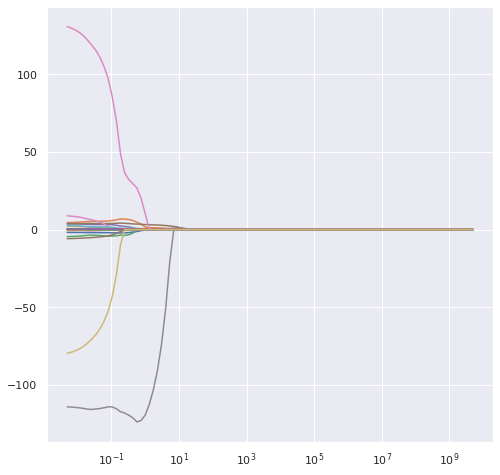

In [268]:
coefs_l = pd.DataFrame(data=coefs_l, columns=list(X.columns), index=alphas)

fig, ax = plt.subplots(figsize=(8,8))
plt.plot(alphas, coefs_l)
ax.set_xscale('log')

Not super visible on the plot, but some of the coefficients are actually zero in many cases. Take a look at `coefs_l` to confirm:

In [270]:
coefs_l

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
5.000000e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
3.782317e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
2.861184e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
2.164381e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
1.637275e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.526928e-02,-1.937969,4.958392,-3.980822,-0.472856,3.480927,3.832849,7.500338,-0.527309,1.719184,2.156888,0.518973,-0.198610,0.042168,0.419571,0.443134,-5.498612,124.770894,-115.276331,-75.247256
1.155065e-02,-1.909585,4.788467,-4.173583,-0.367374,3.603449,3.744681,7.986097,-0.546228,1.830002,2.356883,0.457556,-0.295849,0.073583,0.419935,0.448303,-5.626517,126.953937,-114.903446,-76.873322
8.737642e-03,-1.888085,4.659781,-4.319502,-0.287488,3.696186,3.677920,8.353870,-0.560552,1.913905,2.508287,0.411056,-0.369460,0.097368,0.420210,0.452215,-5.723345,128.606126,-114.621245,-78.103727
6.609706e-03,-1.871803,4.562353,-4.429944,-0.227003,3.766368,3.627379,8.632260,-0.571395,1.977416,2.622886,0.375856,-0.425176,0.115373,0.420418,0.455175,-5.796635,129.856408,-114.407697,-79.034684


To choose our tuning parameter $\alpha$, we perform 10-fold cross-validation. As above with ridge regression, there is a `LassoCV` model available:

In [271]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

104904.36377748138

This is higher than our test error using ridge regression, but still substantially better than the null model and ordinary least squares. One big advantage that the lasso has over ridge regression, however, is that it sets some coefficients to exactly zero, yielding a more readable model. Let's take a look:

In [273]:
pd.Series(lasso.coef_, index = X.columns)

AtBat           0.000000
Hits            1.089755
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           2.921569
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.223579
CRuns           0.000000
CRBI            0.515025
CWalks          0.000000
PutOuts         0.369934
Assists        -0.000000
Errors         -0.000000
League_N        0.000000
Division_W    -90.878889
NewLeague_N     0.000000
dtype: float64

Only 6 of the 19 coefficients are nonzero!